In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
using LinearAlgebra
using Plots
using ForwardDiff
using Ipopt
using StaticArrays
using TrajectoryOptimization
using Altro
using RobotDynamics
using Colors
using CoordinateTransformations
using GeometryBasics
using MeshCat
using Rotations

 Activating environment at `C:\Users\brand\OneDrive\Documents\College Stuff\Research notes\REx\TrajectoryOptimization.jl\examples\Hybrid Examples\Project.toml`


## 2D Hopper

The 2D hopper is composed of a prismatic joint and a revolute joint, and makes the assumption that torque effects are equal and opposite at the head and foot. An image is shown below (copy that image in when you have time). It is parameterized by the following:  

$$ x = \begin{bmatrix} 
        x_{head} \\
        y_{head} \\
        x_{foot} \\
        y_{foot} \\
        \dot x_{head} \\
        \dot y_{head} \\
        \dot x_{foot} \\
        \dot y_{foot} \\
       \end{bmatrix} $$
        
$$ u = \begin{bmatrix}
        F_{pris} \\
        F_{rev} \\
        F_{contact} \\
       \end{bmatrix} $$

In [2]:
# 2D Hopper, parameterized by the following:
function dynamics_2d(x, u)
    # x is a 8d vec, u is a 3d vec
    mh = 1.0
    mf = 1.0
    l = 1.0
    g = 9.81
    v = x[5:8]
    
    headVec = x[1:2]
    footVec = x[3:4]
    xDirec = (headVec[1] - footVec[1]) / norm(headVec - footVec)
    yDirec = (headVec[2] - footVec[2]) / norm(headVec - footVec)
    
    J = u[1]
    T = u[2]
    λ = u[3]
    
    axh = 1/mh * (J*xDirec + l*yDirec*T)
    ayh = 1/mh * (J*yDirec - l*xDirec*T - mh*g)
    axf = 1/mf * (λ*xDirec - J*xDirec - l*yDirec*T)
    ayf = 1/mf * (λ*yDirec - J*yDirec + l*xDirec*T - mf*g)
    
    return [v; axh; ayh; axf; ayf]
end

function dynamics_2d_rk4(x, u, h)
    #RK4 integration with zero-order hold on u
    f1 = dynamics_2d(x, u)
    f2 = dynamics_2d(x + 0.5*h*f1, u)
    f3 = dynamics_2d(x + 0.5*h*f2, u)
    f4 = dynamics_2d(x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

function jump_map(x)
    #Assume the foot experiences inelastic collisions
    xn = [x[1:2]; 0.0; 0.0]
    return xn
end

struct Hopper <: AbstractModel end
RobotDynamics.state_dim(::Hopper) = 8
RobotDynamics.control_dim(::Hopper) = 3

function RobotDynamics.dynamics(::Hopper,x,u)
    ẋ = dynamics_2d(x, u)
end


In [3]:
# Initialize the visualizer
vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\brand\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8700))

In [4]:
function kinematics(x)
    return [x[1], x[2]]
end

function visualize!(vis, Xs, h)
    r_body = 0.2
    r_foot = 0.1
    r_leg = 0.5*r_foot
    
    setvisible!(vis["/Background"], true)
    headSphere = Sphere(Point3f0(0), convert(Float32, r_body))
    footSphere = Sphere(Point3f0(0), convert(Float32, r_foot))
    legSphere = Sphere(Point3f0(0), convert(Float32, r_leg))
    setobject!(vis["body"], headSphere, MeshPhongMaterial(color = RGBA(1.0, 0.0, 1.0, 1.0)))
    setobject!(vis["foot"], footSphere, MeshPhongMaterial(color = RGBA(1.0, 1.0, 0.0, 1.0)))
    
    n_leg = 100
    for i = 1:n_leg
        setobject!(vis["leg$i"], legSphere, MeshPhongMaterial(color=RGBA(0.0, 0.0, 0.0, 1.0)))
    end
    
    p_leg = [zeros(3) for i = 1:n_leg]
    
    anim = MeshCat.Animation(convert(Int, floor(1.0 / h)))
    
    for t = 1:length(Xs)
        x = Xs[t]
        p_body = [x[1], 0.0, x[2]]
        p_foot = [x[3], 0.0, x[4]]
        
        z_shift = [0.0, 0.0, r_foot]
        zDist = x[2] - x[4]
        xDist = x[1] - x[3]
        
        for i = 1:n_leg
            p_leg[i] .= [xDist/n_leg*i + x[3], 0.0, zDist/n_leg*i + x[4]]
        end
        
        
        
        MeshCat.atframe(anim, t) do 
            settransform!(vis["body"], Translation(p_body + z_shift))
            settransform!(vis["foot"], Translation(p_foot + z_shift))
            
            for i = 1:n_leg
                settransform!(vis["leg$i"], Translation(p_leg[i] + z_shift))
            end
        end
    end
    MeshCat.setanimation!(vis, anim)
end
            

visualize! (generic function with 1 method)

In [61]:
function stance_constraints_2d(model)
    n = state_dim(model)
    m = control_dim(model)
    A1 = zeros(3, n)
    # Pin the foot to the floor
    A1[1, 7] = 1.0
    A1[2, 4] = 1.0
    A1[3, 8] = 1.0
    b1 = SVector{3}([0.0, 0.0, 0.0])
    return LinearConstraint(n, m, A1, b1, Equality(), 1:n)
end

function flight_constraints_2d(model)
    n = state_dim(model)
    m = control_dim(model)
    A2 = zeros(1, m)
    # Constrain the contact forces to be 0
    A2[3] = 1.0
    b2 = SVector{1}(0.0)
    return LinearConstraint(n, m, A2, b2, Equality(), (n+1):(n+m))
end


function bin_mode_list(N, mSteps; iState=1)
    next = 1
    modeList = zeros(1, N)
    for i = 1:N
        modeList[i] = iState
        if mod(i, mSteps) == 0
            iState += next
            next *= -1
        end
    end
    return modeList
end

bin_mode_list (generic function with 1 method)

## Forward hopping motions


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 56
    Solve Time: 554.052701 (ms)

  Covergence
    Terminal Cost: 17065.361762190234
    Terminal dJ: 7.428211756632663e-5
    Terminal gradient: 1.5750801663441322e-5
    Terminal constraint violation: 0.0004886092037093689
    Solve Status: SOLVE_SUCCEEDED


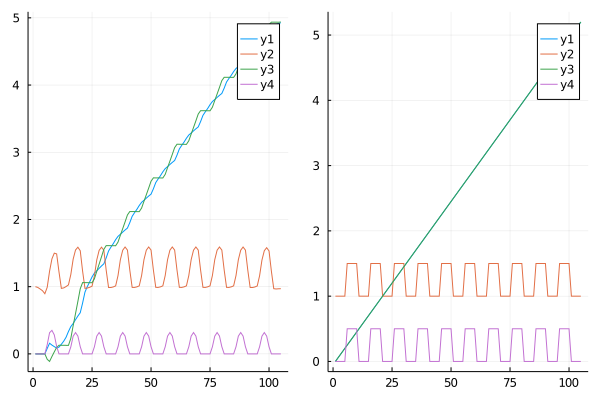

In [60]:
begin
    model = Hopper()
    n = state_dim(model)
    m = control_dim(model)
    N = 105
    h = 0.1
    mSteps = 5
    
    modeList = bin_mode_list(N, mSteps)
    
    g = 9.81
    ueq = [g, 0.0, 2*g]
    currX = [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    
    # Create the cost
    costInit = Diagonal([5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0])
    Q = 500.0 * costInit
    
    Qf = 250.0 * I(n)

    R = 0.1 * I(m)
    
    xRefSimp = zeros(n, N)
    xRefSimp[2, :] .= 1.0
    uRefSimp = zeros(m, N-1)

    for i = 2:N
        if modeList[i] != 1    
            xRefSimp[2, i] = 1.5
            xRefSimp[4, i] = 0.5
        end
        xRefSimp[1, i] = xRefSimp[1, i-1] + 0.05
        xRefSimp[3, i] = xRefSimp[3, i-1] + 0.05
    end

    # xRefSimp[:, end] .= xRefSimp[:, 1]
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    
    # Add in the constraints
    conSet = ConstraintList(n, m, N)
    
    # Stance constraints
    stnc = stance_constraints_2d(model)
    
    # Flight constraints
    flgt = flight_constraints_2d(model)
    
    for i = 1:N-1
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
        else
            add_constraint!(conSet, flgt, i)
        end
    end
    
    
    # Solve ALTRO
    prob = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    p1 = plot(solveX, inds=1:4)
    p2 = plot(XRefSimp, inds=1:4)
    visualize!(vis, solveX, h)
    plot(p1, p2, layout = (1, 2))
    # plot(XRefSimp, inds=1:4)
end


## Back and forth hopping


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 64
    Solve Time: 569.3014 (ms)

  Covergence
    Terminal Cost: 33090.16482416946
    Terminal dJ: 4.36893678852357e-5
    Terminal gradient: 8.788489342801603e-6
    Terminal constraint violation: 1.561132657136427e-5
    Solve Status: SOLVE_SUCCEEDED


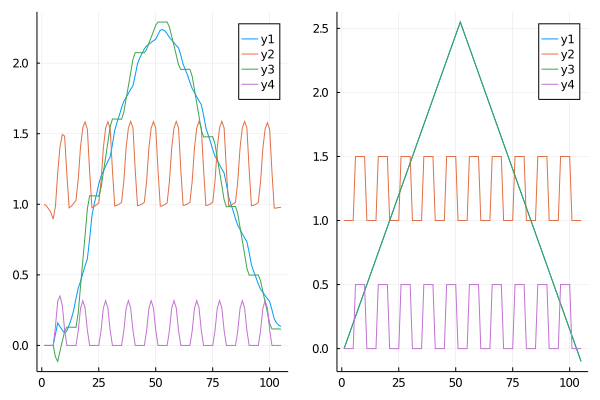

In [57]:
begin
    model = Hopper()
    n = state_dim(model)
    m = control_dim(model)
    N = 105
    h = 0.1
    mSteps = 5
      
    modeList = bin_mode_list(N, mSteps)
    
    g = 9.81
    ueq = [g, 0.0, 2*g]
    currX = [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    
    # Create the cost
    Q = 1000.0 * Diagonal([5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0])
    
    Qf = 1400.0 * I(n)

    R = 0.1 * I(m)
    
    xRefSimp = zeros(n, N)
    xRefSimp[2, :] .= 1.0
    uRefSimp = zeros(m, N-1)
    
    backState = 1
    
    for i = 2:N
        if i > N/2
            xRefSimp[1, i] = xRefSimp[1, i-1] - 0.05
            xRefSimp[3, i] = xRefSimp[3, i-1] - 0.05
        else
            xRefSimp[1, i] = xRefSimp[1, i-1] + 0.05 * backState
            xRefSimp[3, i] = xRefSimp[3, i-1] + 0.05 * backState
        end
            
        if modeList[i] != 1    
            xRefSimp[2, i] = 1.5
            xRefSimp[4, i] = 0.5
        end
        
        
    end

    # xRefSimp[:, end] .= xRefSimp[:, 1]
    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    
    # Add in the constraints
    conSet = ConstraintList(n, m, N)
    
    # Stance constraints
    stnc = stance_constraints_2d(model)
    
    # Flight constraints
    flgt = flight_constraints_2d(model)
    
    for i = 1:N-1
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
        else
            add_constraint!(conSet, flgt, i)
        end
    end
    
    
    # Solve ALTRO
    prob = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    p1 = plot(solveX, inds=1:4)
    p2 = plot(XRefSimp, inds=1:4)
    visualize!(vis, solveX, h)
    plot(p1, p2, layout = (1, 2))
    # plot(XRefSimp, inds=1:4)
end

## Backflip

[1.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 1.0]

SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 83
    Solve Time: 369.3608 (ms)

  Covergence
    Terminal Cost: 2935.3965500655963
    Terminal dJ: 4.69918727503682e-5
    Terminal gradient: 47.597174164910605
    Terminal constraint violation: 1.8006220958710628e-9
    Solve Status: SOLVE_SUCCEEDED


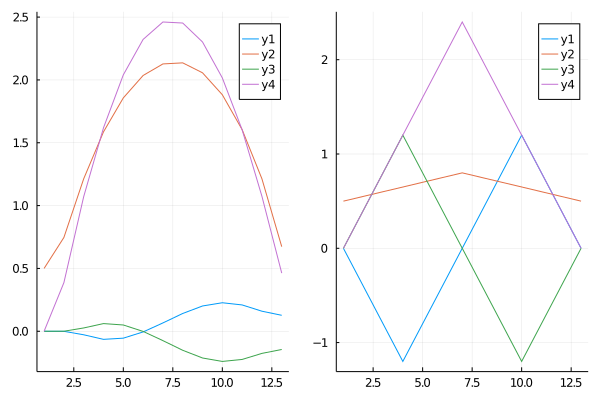

In [152]:
begin
    model = Hopper()
    n = state_dim(model)
    m = control_dim(model)
    N = 13
    h = 0.1
    mSteps = N
      
    modeList = ones(1, N) * 2.0
    modeList[1] = 1.0
    modeList[end] = 1.0
    
    g = 9.81
    ueq = [g, 0.0, 2*g]
    currX = [0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    
    # Create the cost
    Q = 50.0 * Diagonal([5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0])
    
    Qf = 50.0 * Diagonal([5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0])

    R = 0.1* I(m)
    
    xRefSimp = zeros(n, N)
    xRefSimp[:, 1] .= currX
    uRefSimp = zeros(m, N-1)
    
    xShift = 0.4
    yShift = 0.05
    for i = 2:N
        if i-1 <= N/4
            xRefSimp[3, i] = xRefSimp[3, i-1] + xShift
            xRefSimp[2, i] = xRefSimp[2, i-1] + yShift
            xRefSimp[1, i] = xRefSimp[1, i-1] - xShift
            xRefSimp[4, i] = xRefSimp[4, i-1] + xShift
        elseif i-1 > N/4 && i-1 <= N/2
            xRefSimp[3, i] = xRefSimp[3, i-1] - xShift
            xRefSimp[2, i] = xRefSimp[2, i-1] + yShift
            xRefSimp[1, i] = xRefSimp[1, i-1] + xShift
            xRefSimp[4, i] = xRefSimp[4, i-1] + xShift
        elseif i-1 > N/2 && i-1 <= 3*N/4
            xRefSimp[3, i] = xRefSimp[3, i-1] - xShift
            xRefSimp[2, i] = xRefSimp[2, i-1] - yShift
            xRefSimp[1, i] = xRefSimp[1, i-1] + xShift
            xRefSimp[4, i] = xRefSimp[4, i-1] - xShift
        elseif i-1 > 3*N/4 && i-1 <= N
            xRefSimp[3, i] = xRefSimp[3, i-1] + xShift
            xRefSimp[2, i] = xRefSimp[2, i-1] - yShift
            xRefSimp[1, i] = xRefSimp[1, i-1] - xShift
            xRefSimp[4, i] = xRefSimp[4, i-1] - xShift
        end
    end

    
    XRefSimp = [SVector{n}(xRefSimp[:, i]) for i = 1:N]
    URefSimp = [SVector{m}(ueq) for i = 1:N-1]
    costs = [LQRCost(Q, R, XRefSimp[i], ueq) for i = 1:N-1]
    costs = [costs; LQRCost(Qf, R, XRefSimp[end], ueq)]
    obj = Objective(costs)
    
    # Add in the constraints
    conSet = ConstraintList(n, m, N)
    
    # Stance constraints
    stnc = stance_constraints_2d(model)
    
    # Flight constraints
    flgt = flight_constraints_2d(model)
    println(modeList)
    for i = 1:N-1
        if modeList[i] == 1
            add_constraint!(conSet, stnc, i)
        else
            add_constraint!(conSet, flgt, i)
        end
    end
    
    
    # Solve ALTRO
    prob = Problem(model, obj, XRefSimp[end], N*h, x0=XRefSimp[1], constraints=conSet)
    initial_controls!(prob, URefSimp[1])
    rollout!(prob)
    
    solver = ALTROSolver(prob)  
    set_options!(solver, show_summary=true)
    solve!(solver);
    solveX = states(solver)
    solveU = controls(solver)
    
    p1 = plot(solveX, inds=1:4)
    p2 = plot(XRefSimp, inds=1:4)
    visualize!(vis, solveX, h)
    plot(p1, p2, layout = (1, 2))
    # plot(XRefSimp, inds=1:4)
end